In [1]:
%load_ext autoreload
%autoreload 2
import warnings
import numpy as np
import time
import os
from dotenv import load_dotenv
os.environ["USE_PYGEOS"] = "0"
import napari_sparrow as nas
from spatialdata import read_zarr
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import sample 
import scanpy as sc
import seaborn as sns
import anndata as ad
%run own_and_modified_functions.ipynb
warnings.simplefilter(action='ignore')

the value of the environment variable BASIC_DCT_BACKEND is not in ["JAX","SCIPY"]


In [2]:
OUTPUT_DIR = '/home/wout/Documents/Thesis_lokaal/Mouse_Liver_Resolve_Data/'
anndata_objects = []
name_anndata = "A1-1"+"/"+"anndataNucA11"
anndata = sc.read(OUTPUT_DIR + '/' + name_anndata + '_all_0threshold')
anndata_objects.append(anndata)
name_anndata = "A1-2"+"/"+"anndataNucA12"
anndata = sc.read(OUTPUT_DIR + '/' + name_anndata + '_all_0threshold')
anndata_objects.append(anndata)
name_anndata = "C2"+"/"+"anndataNucC2"
anndata = sc.read(OUTPUT_DIR + '/' + name_anndata + '_all_0threshold')
anndata_objects.append(anndata)
name_anndata = "D2-1"+"/"+"anndataNucD21"
anndata = sc.read(OUTPUT_DIR + '/' + name_anndata + '_all_0threshold')
anndata_objects.append(anndata)
name_anndata = "PS"+"/"+"ps_slice"
anndata = sc.read(OUTPUT_DIR + '/' + name_anndata + '_all_0threshold')
anndata_objects.append(anndata)
samples = ["A1-1", "A1-2", "C2", "D2-1", "PS"]

In [3]:
for anndata in anndata_objects:
    print(anndata.shape)

(11283, 99)
(8695, 95)
(27133, 100)
(12519, 99)
(11794, 96)


In [3]:
# Give Leiden clusters unique numbers over all samples
nr_leiden_clusters = []
for i in range(len(anndata_objects)):
    nr_leiden_clusters.append(len(np.unique(anndata_objects[i].obs['leiden'])))
    anndata_objects[i].obs['leiden'] = anndata_objects[i].obs['leiden'].astype(int) + sum(nr_leiden_clusters[:i])
    anndata_objects[i].obs['leiden'] = anndata_objects[i].obs['leiden'].astype(str)
    anndata_objects[i].obs['leiden'] = anndata_objects[i].obs['leiden'].astype('category')

In [4]:
anndata_samples_together = anndata_objects[0].concatenate(anndata_objects[1],anndata_objects[2],anndata_objects[3],anndata_objects[4])

In [45]:
score_name = 'own_score_genes_Atlas_Scores_12'
score_matrices = []
for i in range(len(anndata_objects)):
    score_matrices.append(anndata_objects[i].uns[score_name])
score_matrix_together = pd.concat(score_matrices)
# set smaller than 0 to NaN
score_matrix_together[score_matrix_together < 0] = np.nan


In [46]:
score_matrix_together

,LSEC,Portal LAM,Central vein,Portal vein,Hepa,Chol,B cell,Kupf,Meso,Stel,Fibr,Oth im
0,NaN,NaN,NaN,NaN,0.042882,NaN,NaN,NaN,4.076829,NaN,0.469486,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.070779,2.548261,NaN,0.173734,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.266527,NaN,0.487380,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.150336,NaN,0.533665,0.125935
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.030639,2.283911,0.509969,3.160597,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
11789,0.484860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.178282,0.117237,NaN
11790,0.976746,NaN,1.793332,5.398909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.141259
11791,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.717851,NaN
11792,NaN,NaN,NaN,NaN,0.054872,NaN,NaN,0.378865,0.711671,1.511771,3.735958,NaN


In [47]:
score_matrix_together_max = score_matrix_together.copy()
for i in range(score_matrix_together_max.shape[0]):
    max_value = score_matrix_together_max.iloc[i,:].max()
    score_matrix_together_max.iloc[i,score_matrix_together_max.iloc[i,:] < max_value] = np.nan

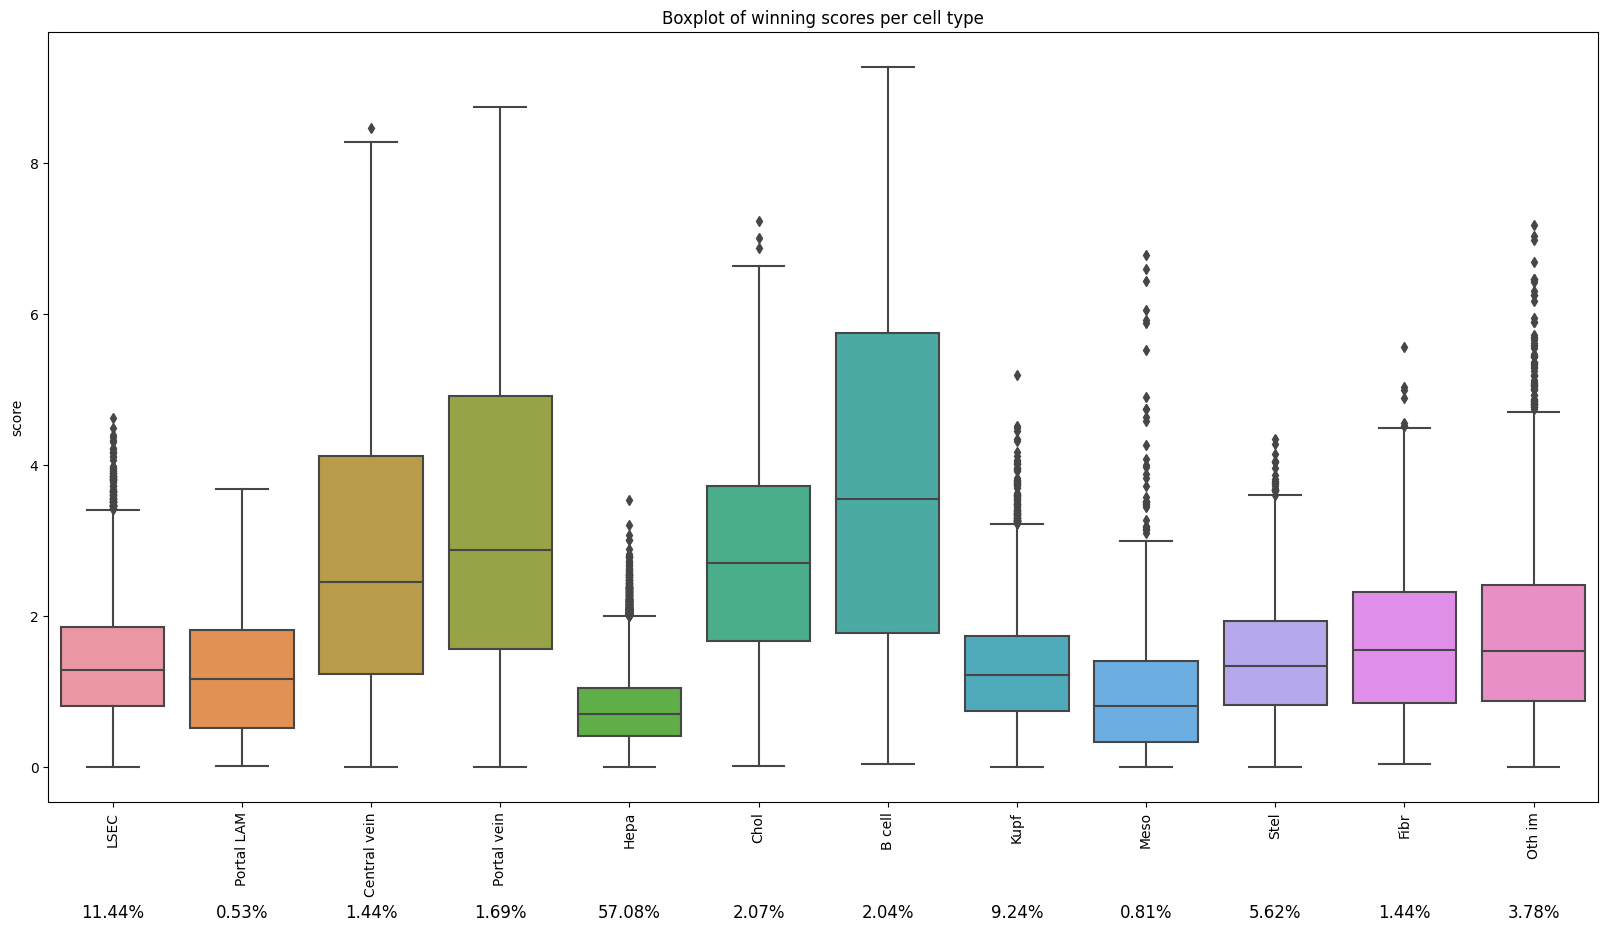

In [48]:
fig, ax = plt.subplots(1,1,figsize=(20,10))
sns.boxplot(data=score_matrix_together_max,ax=ax)
plt.xticks(rotation=90)
plt.title('Boxplot of winning scores per cell type')
plt.ylabel('score')
# add to each x label the percentage that is not NaN
for i in range(len(ax.get_xticklabels())):
    ax.text(i,-2,str(round(100*sum(score_matrix_together_max.iloc[:,i]>0)/len(score_matrix_together_max.iloc[:,i]),2))+'%',ha='center', fontsize=12)
plt.show()

In [ ]:
annotation = 'annotation_score_genes_original_Atlas_Scores_12'
cell_types = anndata_samples_together.obs[annotation].unique().tolist()  
# move 'Unknown' to last place
cell_types.remove('Unknown')
cell_types.append('Unknown')
# remove 'Hepa' from cell_types
cell_types_no_hepa = [x for x in cell_types if x != 'Hepa']
leiden_clusters_per_ct = clusteringVSleiden(anndata_samples_together,annotation,"leiden",cell_types=cell_types,print_results=True,cell_types_in_homog_plot=cell_types_no_hepa,homog_plot_only_hepa=True)

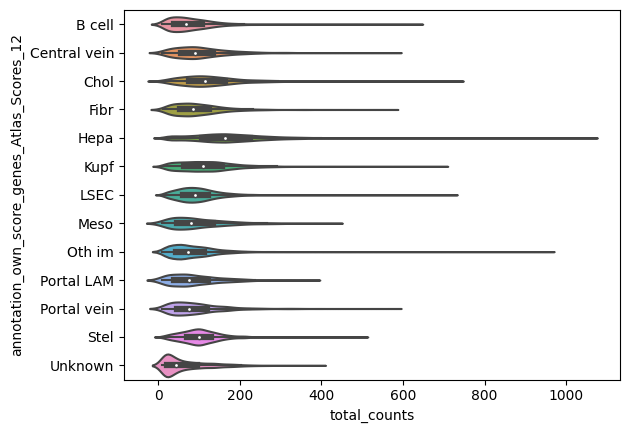

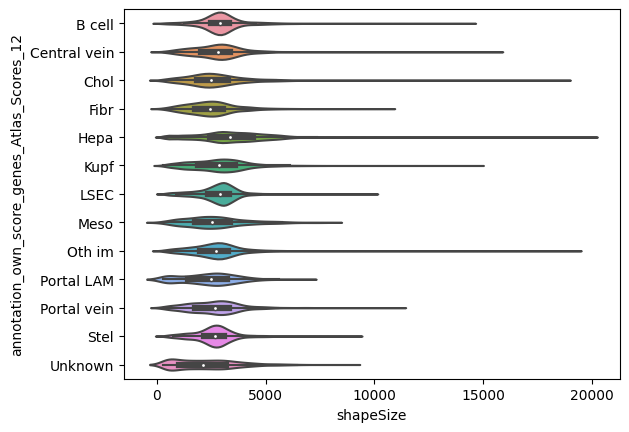

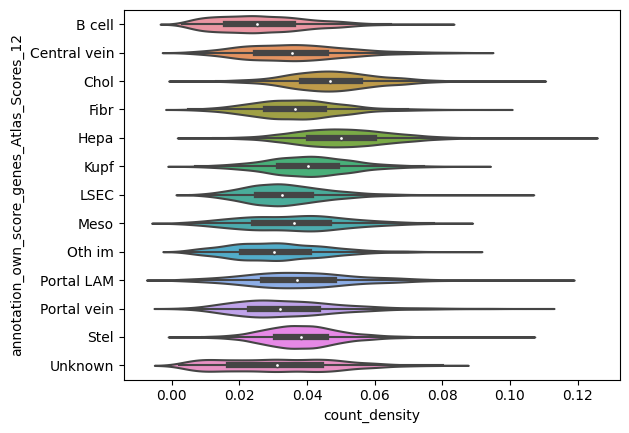

In [10]:
anndata = anndata_samples_together
annotation = 'annotation_own_score_genes_Atlas_Scores_12'
sns.violinplot(data=anndata.obs,x="total_counts",y=annotation)
plt.show()
sns.violinplot(data=anndata.obs,x="shapeSize",y=annotation)
plt.show()
anndata.obs['count_density'] = anndata.obs['total_counts'] / anndata.obs['shapeSize']
sns.violinplot(data=anndata.obs,x="count_density",y=annotation)
plt.show()

In [6]:
annotation = 'annotation_score_genes_original_Atlas_Scores_12'
path_mg = "/home/wout/Documents/Thesis_lokaal/Mouse_Liver_Resolve_Data/AtlasSecondLevelScores.csv"
name = 'Atlas Scores'
# drop first 11 characters
annotation_scores = annotation[11:]

Text(0.5, 1.0, 'Score correlation matrix Atlas Scores')

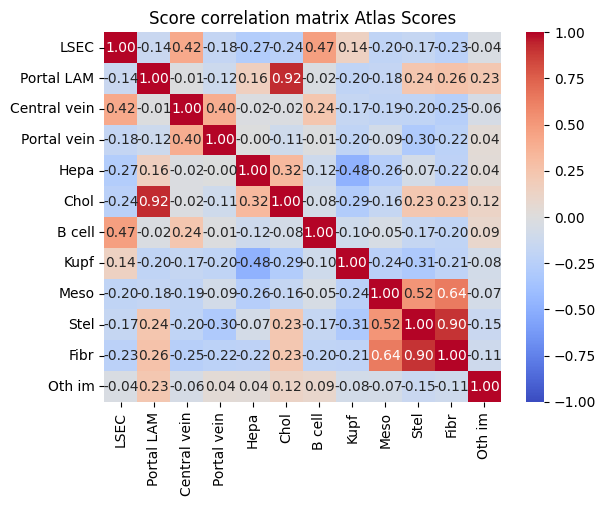

In [7]:
corr_matrices = []
for anndata in anndata_objects:
    scores = anndata.uns[annotation_scores]
    corr_matrix = scores.corr(method='pearson')
    corr_matrices.append(corr_matrix)   
# average df in corr_matrices
average_corr_matrix = sum(corr_matrices)/len(corr_matrices)
average_corr_matrix
# make heatmap
sns.heatmap(average_corr_matrix, annot=True,fmt='.2f',vmin=-1, vmax=1, cmap='coolwarm')
# add title
plt.title('Score correlation matrix '+name)

LSEC            35.043773
Portal LAM      38.318140
Central vein    30.194304
Portal vein     23.242989
Hepa            38.836789
Chol            44.781174
B cell          25.424346
Kupf            90.001786
Meso            50.835620
Stel            95.425520
Fibr            92.048523
Oth im          28.104598
dtype: float64


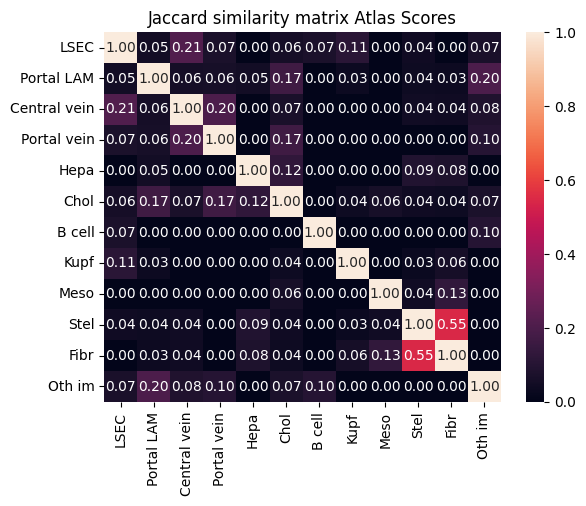

In [8]:
Jacc_m = Jaccard_similarity_matrix(path_mg,name)

Text(0.5, 1.0, 'Score correlation - Jaccard matrix Atlas Scores')

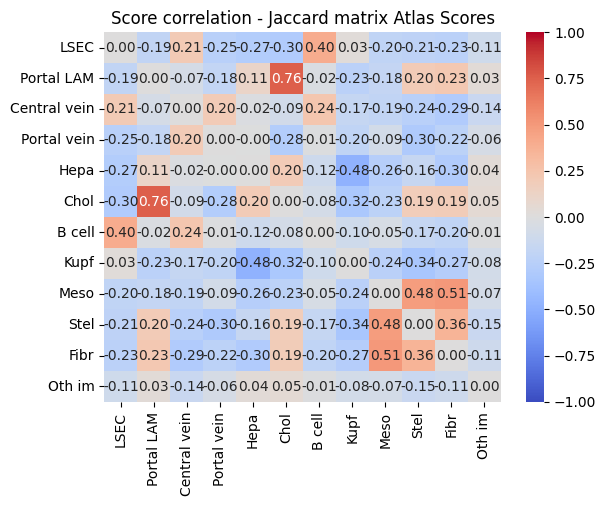

In [9]:
# subtract matrices
diff_matrix = average_corr_matrix - Jacc_m
sns.heatmap(diff_matrix, annot=True,fmt='.2f',vmin=-1, vmax=1, cmap='coolwarm')
plt.title('Score correlation - Jaccard matrix '+name)